In [277]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import functions_sandbox as sand

In [278]:
path = r"D:\IT_projects\Turing_Colledge\Modul3\Sprint1\project\travel_insurance.csv"

travelin = pd.read_csv(path)

In [279]:
travelin.head(3)

,Unnamed: 0,Age,Employment Type,GraduateOrNot,AnnualIncome,FamilyMembers,ChronicDiseases,FrequentFlyer,EverTravelledAbroad,TravelInsurance
0,0,31,Government Sector,Yes,400000,6,1,No,No,0
1,1,31,Private Sector/Self Employed,Yes,1250000,7,0,No,No,0
2,2,34,Private Sector/Self Employed,Yes,500000,4,1,No,No,1


In [280]:
travelin = travelin.drop(columns=travelin.columns[0])

In [281]:
travelin = sand.cleaner(travelin)
travelin = travelin.rename(columns={"employment type":"employment_type"})

All columns empty spaces have been stripped.
All columns names have been converted to lowercase.

Is there any duplicates?: True
Is there any NaN numbers?: False
Is there any empty cells?: False


In [282]:
travelin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   age                  1987 non-null   int64 
 1   employment_type      1987 non-null   object
 2   graduateornot        1987 non-null   object
 3   annualincome         1987 non-null   int64 
 4   familymembers        1987 non-null   int64 
 5   chronicdiseases      1987 non-null   int64 
 6   frequentflyer        1987 non-null   object
 7   evertravelledabroad  1987 non-null   object
 8   travelinsurance      1987 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 139.8+ KB


- Employment type: could be changed to 0 and 1 (private=0, gov=1)  
- Graduate or Not: could be changed to 0 and 1 (no=0, yes=1) 
- Frequent flier: could be changed to 0 and 1 (no=0, yes=1)  
- Ever travelled abroad: could be changed to 0 and 1 (no=0, yes=1)

In [283]:
columns = len(travelin.columns)

for col in range(columns):
    print(f"{travelin.columns[col]}: {travelin.iloc[:,col].unique()}")

age: [31 34 28 25 33 26 32 29 35 30 27]
employment_type: ['Government Sector' 'Private Sector/Self Employed']
graduateornot: ['Yes' 'No']
annualincome: [ 400000 1250000  500000  700000 1150000 1300000 1350000 1450000  800000
 1400000  850000 1500000 1050000  350000 1100000  600000  900000  550000
  300000  750000 1200000 1000000  950000 1700000 1750000  650000  450000
 1650000 1800000 1550000]
familymembers: [6 7 4 3 8 9 5 2]
chronicdiseases: [1 0]
frequentflyer: ['No' 'Yes']
evertravelledabroad: ['No' 'Yes']
travelinsurance: [0 1]


Depending on a given rezult, values of several features will be  
transferred to 0's/1's bias type. Additionally, annual income will be  
changed to millions in order to shorten numbers lenght.

In [284]:
travelin = travelin.copy()
travelin["graduateornot"] = travelin["graduateornot"].apply(
    lambda x: 0 if x == "No" else 1
)
travelin["frequentflyer"] = travelin["frequentflyer"].apply(
    lambda x: 0 if x == "No" else 1
)
travelin["evertravelledabroad"] = travelin["evertravelledabroad"].apply(
    lambda x: 0 if x == "No" else 1
)
travelin["employment_type"] = travelin["employment_type"].apply(
    lambda x: 0 if x == "Private Sector/Self Employed" else 1
)
travelin["annualincome"] = travelin["annualincome"].apply(
    lambda x: x / 1000000
)

In [285]:
travelin.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1987.0,29.650226,2.913308,25.0,28.0,29.0,32.00,35.0
employment_type,1987.0,0.286865,0.452412,0.0,0.0,0.0,1.00,1.0
graduateornot,1987.0,0.851535,0.355650,0.0,1.0,1.0,1.00,1.0
annualincome,1987.0,0.932763,0.376856,0.3,0.6,0.9,1.25,1.8
familymembers,1987.0,4.752894,1.609650,2.0,4.0,5.0,6.00,9.0
chronicdiseases,1987.0,0.277806,0.448030,0.0,0.0,0.0,1.00,1.0
frequentflyer,1987.0,0.209864,0.407314,0.0,0.0,0.0,0.00,1.0
evertravelledabroad,1987.0,0.191243,0.393379,0.0,0.0,0.0,0.00,1.0
travelinsurance,1987.0,0.357323,0.479332,0.0,0.0,0.0,1.00,1.0


We have customers between 25 and 35 years. Most of the customers are graduated college  
and average anual income is about 932k rupees. Customer's family consists of min 2  
family members to max 9.

Now we have two types of data:  
- continuous: age, annualincome  
- categorical: where employment type, graduate/not, chronic diseases,  
frequentflyer, ever travelled abroad, travelinsurance are discrete binary  
and family members standard discrete.  
With this info we can make two dataframes for both types.

In [ ]:
travel_cont = travelin[["age", "annualincome", "travelinsurance"]]
travel_cate = travelin[
    [
        "employment_type",
        "graduateornot",
        "familymembers",
        "chronicdiseases",
        "frequentflyer",
        "evertravelledabroad",
        "travelinsurance",
    ]
]

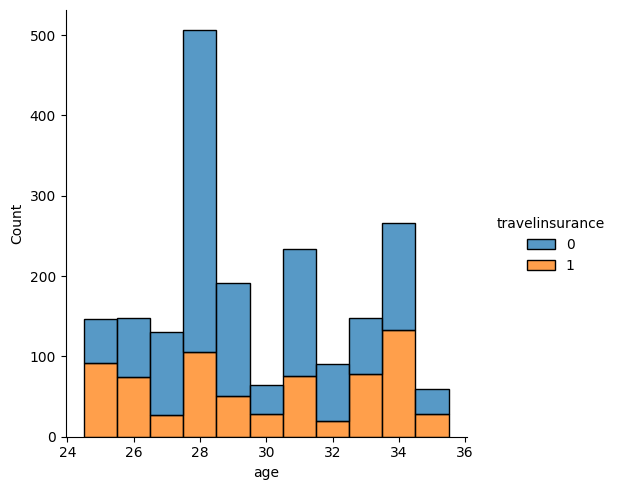

In [331]:
sns.displot(
    travel_cont, x="age", hue="travelinsurance", multiple="stack", discrete=True
)
plt.show()

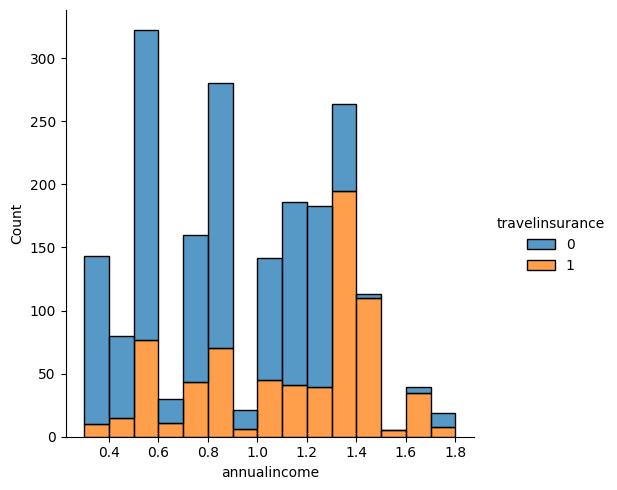

In [334]:
sns.displot(
    travel_cont, x="annualincome", hue="travelinsurance", multiple="stack"
)
plt.show()